## DJF Anomlies

Here, we plot the JDF anomlies in overturning against SST, Heat flux etc. anomalies. This is just get a sense if there is any linear correlation. This step is useful for making hypothesis and pursuing more sophisticated approaches.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read anomaly data for overturning and other state variables

# -------- Full data in overturning and heat/salt transport -----------------

ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl']

ds_psi = []

stride_year = 1

for year in range(1960, 2017 , stride_year):
    
    d = xr.open_dataset(ppdir + str(year) + "_diaptr.nc", decode_times= False, chunks={'r':1})
    d = d.get(var_list)
    ds_psi.append(d)
    
ds_psi = xr.concat(ds_psi, dim='start_year')
ds_psi = ds_psi.assign(start_year = np.arange(1960, 2017, stride_year))
ds_psi = ds_psi.chunk({'start_year': 1})

ds_psi = xr.decode_cf(ds_psi)

print(ds_psi)

### ------------- Drift data in overturning and heat/salt transport -----------------

ppdir1="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_2016_DCPP/"
ds_psi_drift = []
    
for lead_year in range(0, 11):
    
    d = xr.open_dataset(ppdir1 + "Drift_diaptr_Lead_Year_" + str(lead_year + 1) + ".nc", decode_times= False)
    d = d.get(var_list)
    ds_psi_drift.append(d)
        
ds_psi_drift = xr.concat(ds_psi_drift, dim='lead_year')

print(ds_psi_drift)

### ------------ Anomaly data ----------------------

ppdir1="/home/users/hkhatri/DePreSys4_Data/"

ds_anom = []

var_list2 = ['hfds', 'tos', 'sos']

for var in var_list2:
    
    ds = []
    
    for i in range(0,9):
    
        d = xr.open_dataset(ppdir1 + "Data_Anomaly_Compute/Anomaly_" + var + "_r" + str(i+1) + ".nc")
        
        ds.append(d)
    
    ds = xr.concat(ds, dim='r')
    
    ds_anom.append(ds)

ds_anom = xr.concat(ds_anom, dim='var')

print(ds_anom)

<xarray.Dataset>
Dimensions:            (start_year: 57, r: 10, time_counter: 125, y: 451, x: 1, depthw: 75)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(451, 1), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(451, 1), meta=np.ndarray>
    time_centered      (start_year, time_counter) object dask.array<chunksize=(1, 125), meta=np.ndarray>
  * time_counter       (time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: r, y, x
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(1, 1, 125, 451, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(1, 1, 125, 451, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, dep

In [3]:
# Resample by winter season for psi data and compute anomaly

ds =ds_psi.copy()
ds['time'] = ds['time_centered'].isel(start_year=0)
ds = ds.assign_coords(time_counter=ds.time)

ds_psi_resam = ds.resample(time_counter='QS-DEC').mean('time_counter')
ds_psi_resam = ds_psi_resam.sel(time_counter = ds_psi_resam['time_counter.season'] == 'DJF').mean(['x'])

ds_psi_anom = (ds_psi_resam.transpose('start_year', 'time_counter','r','y', 'depthw').rename({'time_counter': 'lead_year'}).max(dim='depthw')  - 
               ds_psi_drift.mean(['x']).max(dim='depthw'))

ds_psi_anom = ds_psi_anom.assign_coords(y=ds.nav_lat.isel(x=0))
#ds_psi_aom = ds_psi_resam.sel(y=[50.], method="nearest")

In [4]:
print(ds_psi_anom)

<xarray.Dataset>
Dimensions:            (lead_year: 11, start_year: 57, r: 10, y: 451)
Coordinates:
  * lead_year          (lead_year) object 1960-12-01 00:00:00 ... 1970-12-01 ...
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
    nav_lat            (y) float32 dask.array<chunksize=(451,), meta=np.ndarray>
    nav_lon            (y) float32 dask.array<chunksize=(451,), meta=np.ndarray>
  * y                  (y) float32 3.997 4.246 4.495 4.745 ... 79.85 79.92 79.99
Dimensions without coordinates: r
Data variables:
    hfbasin_atlantic   (start_year, lead_year, r, y) float32 dask.array<chunksize=(1, 1, 1, 451), meta=np.ndarray>
    sltbasin_atlantic  (start_year, lead_year, r, y) float32 dask.array<chunksize=(1, 1, 1, 451), meta=np.ndarray>
    zomsfatl           (start_year, lead_year, r, y) float32 dask.array<chunksize=(1, 1, 1, 451), meta=np.ndarray>


In [5]:
lat =[40., 45., 50., 55., 60.]

psi = ds_psi_anom['zomsfatl'].sel(y=lat, method="nearest").compute()
HT = ds_psi_anom['hfbasin_atlantic'].sel(y=lat, method="nearest").compute()
#ST = ds_psi_anom['sltbasin_atlantic'].sel(y=lat, method="nearest").compute()
#print(psi)

In [8]:
print(HT)

<xarray.DataArray 'hfbasin_atlantic' (start_year: 57, lead_year: 11, r: 10, y: 5)>
array([[[[-9.23773050e-02,  1.33037716e-01,  1.78789020e-01,
           1.12595618e-01,  6.90143406e-02],
         [ 5.12034297e-02,  1.23877227e-01,  1.11973763e-01,
           7.21647739e-02,  2.73752213e-02],
         [-1.75110102e-02, -4.71333265e-02, -6.10201955e-02,
          -1.83945298e-02,  1.50241554e-02],
         ...,
         [ 3.53331566e-02, -7.35494792e-02, -1.03846192e-02,
           3.69095802e-03,  3.48734856e-03],
         [ 4.71249819e-02, -1.18719190e-01, -1.30286664e-01,
          -3.68742943e-02,  2.86418200e-02],
         [-1.42257571e-01, -1.59070849e-01, -2.68220305e-02,
           4.41576242e-02,  6.48027956e-02]],

        [[-2.03747004e-01,  7.26950169e-02,  4.51334119e-02,
           1.54873729e-02,  3.13458443e-02],
         [ 2.20814049e-01,  3.19061279e-02, -3.14663053e-02,
          -6.72517121e-02, -8.25221539e-02],
         [-1.68568492e-02, -5.16641736e-02, -5.036258

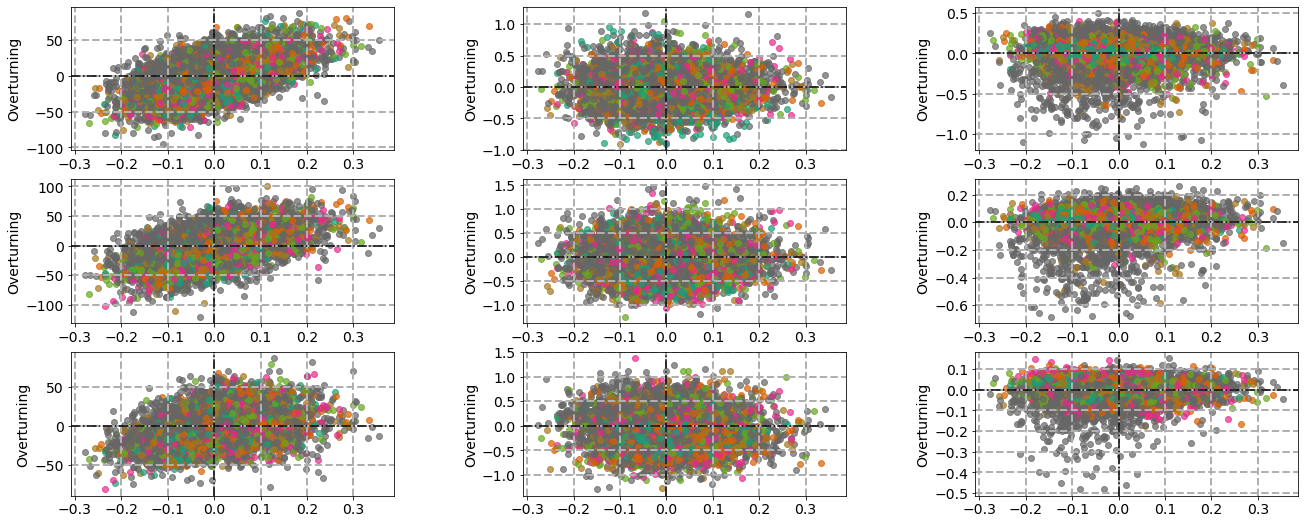

In [9]:
grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.2)
fig = plt.figure(figsize=[22,9])

region_list = ['Labrador_Sea', 'Irminger_Sea', 'Iceland_Basin']
var_list = ['hfds', 'tos', 'sos']

col = plt.cm.Dark2(np.linspace(0.,2., 11))
               
i = 0
for region in region_list:
    
    j = 0
    
    for var in var_list:
        
        ax = fig.add_subplot(grid[i, j])
        
        for start_year in range(0, len(psi.start_year), 1):
            for lead_year in range(0,11):
                
                ax.scatter(HT.isel(start_year=start_year, lead_year=lead_year, r=slice(0,9), y =2), 
                           ds_anom[region].isel(var = j, start_year=start_year, lead_year=lead_year), color=col[lead_year], alpha=0.7)
                ax.grid('on', lw=2, ls='--')
                
        ax.set_ylabel('Overturning', fontsize=14)
        ax.axhline(y=0.0, color="k", linestyle="-.") 
        ax.axvline(x=0.0, color="k", linestyle="-.") 
        plt.yticks(fontsize = 14)
        plt.xticks(fontsize = 14)
        
        j = j +1
        
    i = i+1

#### Correlation

Heat flux anomlies and northward Heat transport seem to correlate positively in some regions (Labrador, Irminger, North East). There is no obvious correlation wth SST/SSS. Let's stidck with Overturning and northward heat transport.

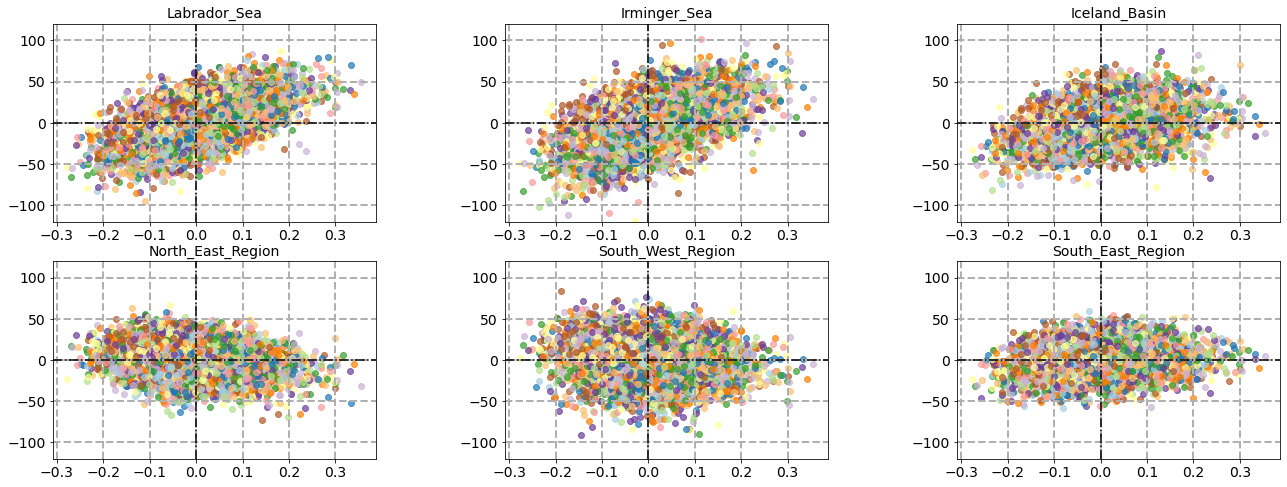

In [7]:
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.2)
fig = plt.figure(figsize=[22,8])

region_list = ['Labrador_Sea', 'Irminger_Sea', 'Iceland_Basin', 'North_East_Region' ,'South_West_Region', 'South_East_Region']
var_list = ['hfds']

lat1 = 50.
col = plt.cm.Paired(np.linspace(0.,1., 11))
               
i = 0
for region in region_list:
    
    j = 0
    
    for var in var_list:
        
        ax = fig.add_subplot(grid[int(i/3), i - 3*int(i/3)])
        
        for start_year in range(0, len(psi.start_year), 1):
            for lead_year in range(0,11):
                
                ax.scatter(HT.isel(start_year=start_year, lead_year=lead_year, r=slice(0,9)).sel(y=lat1, method="nearest"), 
                           ds_anom[region].isel(var = j, start_year=start_year, lead_year=lead_year), color=col[lead_year], alpha=0.7)
                ax.grid('on', lw=2, ls='--')
                
        #ax.set_ylabel('Overturning', fontsize=14)
        ax.axhline(y=0.0, color="k", linestyle="-.") 
        ax.axvline(x=0.0, color="k", linestyle="-.") 
        #ax.set_xlim([-.5, 0.5])
        ax.set_ylim([-120., 120.])
        ax.set_title(region, fontsize=14)
        plt.yticks(fontsize = 14)
        plt.xticks(fontsize = 14)
        
        j = j +1
        
    i = i+1

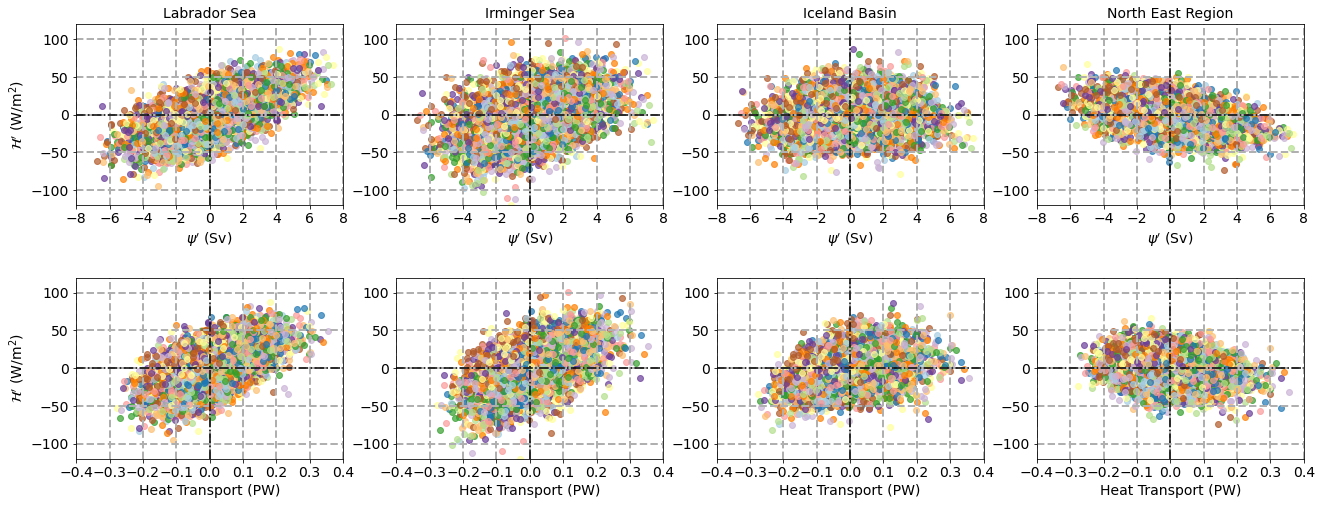

In [9]:
grid = plt.GridSpec(2, 4, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[22,8])

region_list = ['Labrador_Sea', 'Irminger_Sea', 'Iceland_Basin', 'North_East_Region']
tilt_name = ['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'North East Region']
var_list = ['hfds']
lat1 = 50.

col = plt.cm.Paired(np.linspace(0.,1., 11))
               
i = 0
for region in region_list:
    
    for var in var_list:
        
        ax = fig.add_subplot(grid[0, i])
        
        for start_year in range(0, len(psi.start_year), 1):
            for lead_year in range(0,11):
                
                ax.scatter(psi.isel(start_year=start_year, lead_year=lead_year, r=slice(0,9)).sel(y=lat1, method="nearest"), 
                           ds_anom[region].isel(var = 0, start_year=start_year, lead_year=lead_year), color=col[lead_year], alpha=0.7)
                ax.grid('on', lw=2, ls='--')
        
        if(i==0):
            ax.set_ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)', fontsize=14)
        ax.set_xlabel(r'$\psi^{\prime}$ (Sv)', fontsize=14)
        ax.axhline(y=0.0, color="k", linestyle="-.") 
        ax.axvline(x=0.0, color="k", linestyle="-.") 
        ax.set_xlim([-8., 8.])
        ax.set_ylim([-120., 120.])
        ax.set_title(tilt_name[i], fontsize=14)
        plt.yticks(fontsize = 14)
        plt.xticks(fontsize = 14)
        
        ax = fig.add_subplot(grid[1, i])
        
        for start_year in range(0, len(psi.start_year), 1):
            for lead_year in range(0,11):
                
                ax.scatter(HT.isel(start_year=start_year, lead_year=lead_year, r=slice(0,9)).sel(y=lat1, method="nearest"), 
                           ds_anom[region].isel(var = 0, start_year=start_year, lead_year=lead_year), color=col[lead_year], alpha=0.7)
                ax.grid('on', lw=2, ls='--')
        
        if(i==0):
            ax.set_ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)', fontsize=14)
        ax.set_xlabel(r'Heat Transport (PW)', fontsize=14)
        ax.axhline(y=0.0, color="k", linestyle="-.") 
        ax.axvline(x=0.0, color="k", linestyle="-.") 
        ax.set_xlim([-.4, 0.4])
        ax.set_ylim([-120., 120.])
        plt.yticks(fontsize = 14)
        plt.xticks(fontsize = 14)
        
    i = i+1

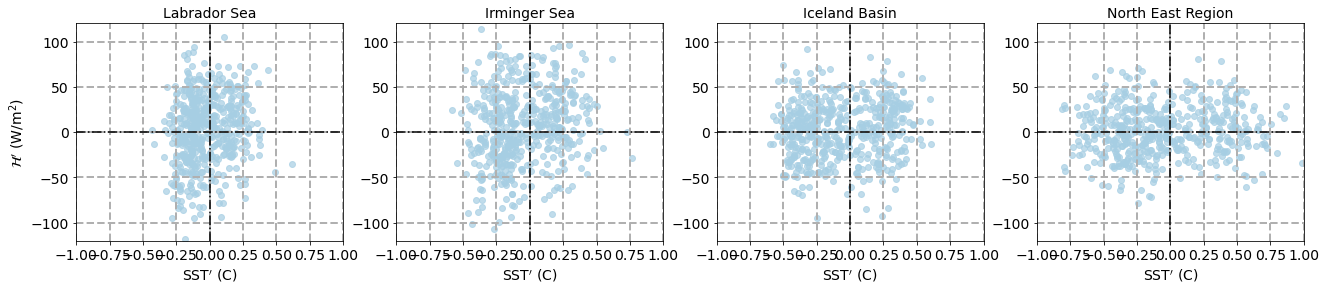

In [16]:
grid = plt.GridSpec(1, 4, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[22,4])

region_list = ['Labrador_Sea', 'Irminger_Sea', 'Iceland_Basin', 'North_East_Region']
tilt_name = ['Labrador Sea', 'Irminger Sea', 'Iceland Basin', 'North East Region']
var_list = ['hfds']
lat1 = 50.

col = plt.cm.Paired(np.linspace(0.,1., 11))
               
i = 0
for region in region_list:
    
    for var in var_list:
        
        ax = fig.add_subplot(grid[0, i])
        
        for start_year in range(0, len(psi.start_year), 1):
        #for lead_year in range(0,11):
                
            ax.scatter(ds_anom[region].isel(var = 1, start_year=start_year).mean('lead_year'), 
                        ds_anom[region].isel(var = 0, start_year=start_year, lead_year=10) - 
                        ds_anom[region].isel(var = 0, start_year=start_year, lead_year=0), 
                        color=col[lead_year], alpha=0.7)
        
        ax.grid('on', lw=2, ls='--')
        
        if(i==0):
            ax.set_ylabel(r'$\mathcal{H}^{\prime}$ (W/m$^2$)', fontsize=14)
        ax.set_xlabel(r'SST$^{\prime}$ (C)', fontsize=14)
        ax.axhline(y=0.0, color="k", linestyle="-.") 
        ax.axvline(x=0.0, color="k", linestyle="-.") 
        ax.set_xlim([-1., 1.])
        ax.set_ylim([-120., 120.])
        ax.set_title(tilt_name[i], fontsize=14)
        plt.yticks(fontsize = 14)
        plt.xticks(fontsize = 14)
        
    i = i+1

In [11]:
print(ds_anom)

<xarray.Dataset>
Dimensions:            (var: 3, r: 9, start_year: 57, lead_year: 11)
Dimensions without coordinates: var, r, start_year, lead_year
Data variables:
    Labrador_Sea       (var, r, start_year, lead_year) float32 4.522 ... -0.9091
    Irminger_Sea       (var, r, start_year, lead_year) float32 43.33 ... -0.5115
    Iceland_Basin      (var, r, start_year, lead_year) float32 19.4 ... -0.3765
    North_East_Region  (var, r, start_year, lead_year) float32 2.923 ... -0.9594
    South_West_Region  (var, r, start_year, lead_year) float32 -30.96 ... -0....
    South_East_Region  (var, r, start_year, lead_year) float32 -6.573 ... -0....
    North_Atlantic     (var, r, start_year, lead_year) float32 -9.218 ... -0....


In [18]:
ds_mask = xr.open_dataset('/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_Regions.nc')

print(ds_mask)

<xarray.Dataset>
Dimensions:         (j: 450, i: 450)
Coordinates:
  * j               (j) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * i               (i) int64 749 750 751 752 753 ... 1194 1195 1196 1197 1198
    nav_lat         (j, i) float32 ...
    nav_lon         (j, i) float32 ...
Data variables:
    mask_regions    (j, i) float64 ...
    mask_North_Atl  (j, i) float64 ...


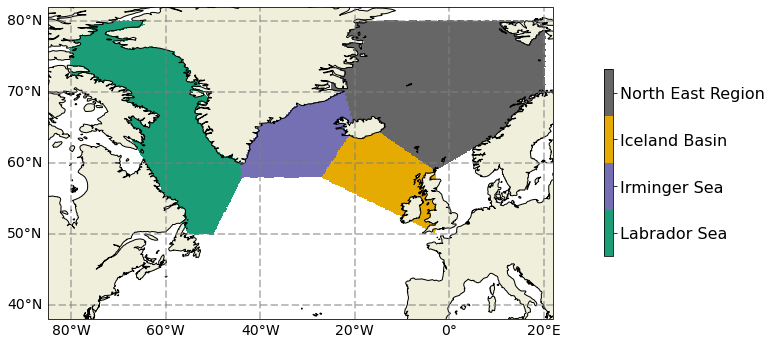

In [75]:
col = plt.cm.get_cmap('Dark2', 4)

grid1 = plt.GridSpec(4, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,12])

tmp = ds_mask['mask_regions'].where(ds_mask['mask_regions']<=3.).assign_coords({'longitude': ds_mask['nav_lon'], 'latitude': ds_mask['nav_lat']})


# mask plot
ax = fig.add_subplot(grid1[0:2, 0:2], projection=ccrs.PlateCarree(), facecolor='none')
kwargs = dict(x='longitude', y='latitude',transform = ccrs.PlateCarree(), infer_intervals=False, add_colorbar=False)
p = tmp.plot(cmap=col, vmin=-0.5, vmax = 3.5, **kwargs) #, cbar_kwargs=dict(shrink=0.8, ticks=[0., 1., 2. , 3.]))
cb = plt.colorbar(p, ax=ax, shrink=0.6)
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticklabels(['Labrador Sea', 'Irminger Sea', 'Iceland Basin','North East Region'], fontsize=16)
#ax.set_title(f"Full Mask")
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax.set_extent([-85., 22., 38., 82.], crs=ccrs.PlateCarree())
ax.set_aspect(1.5)

# parallels/meridiens
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}


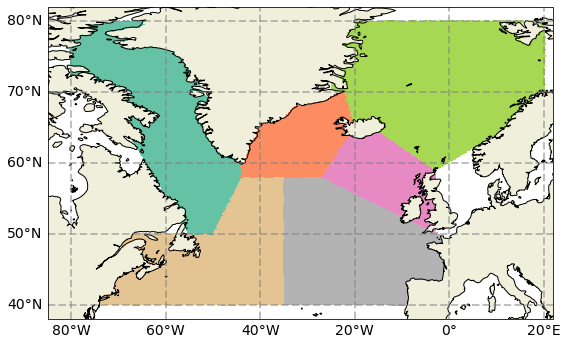

In [29]:
col = plt.cm.get_cmap('Set2', 10)

grid1 = plt.GridSpec(4, 2, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,12])

tmp = ds_mask['mask_regions'].where(ds_mask['mask_regions']<=5.).assign_coords({'longitude': ds_mask['nav_lon'], 'latitude': ds_mask['nav_lat']})


# mask plot
ax = fig.add_subplot(grid1[0:2, 0:2], projection=ccrs.PlateCarree(), facecolor='none')
kwargs = dict(x='longitude', y='latitude',transform = ccrs.PlateCarree(), infer_intervals=False, add_colorbar=False)
p = tmp.plot(cmap=col, vmin=-0.5, vmax = 5.5, **kwargs) #, cbar_kwargs=dict(shrink=0.8, ticks=[0., 1., 2. , 3.]))
#cb = plt.colorbar(p, ax=ax, shrink=0.6)
#cb.ax.tick_params(labelsize=12)
#cb.ax.set_yticklabels(['Labrador Sea', 'Irminger Sea', 'Iceland Basin','North East Region'], fontsize=16)
#ax.set_title(f"Full Mask")
ax.coastlines()
ax.add_feature(cfeature.LAND)

ax.set_extent([-85., 22., 38., 82.], crs=ccrs.PlateCarree())
ax.set_aspect(1.5)

# parallels/meridiens
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}